In [2]:
import requests
import base64
from io import BytesIO
from PIL import Image

URL_API = "http://localhost:5000"

def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


In [3]:
#image_path = "image/coconut.jpg"
image_path = "image/fake.jpg"

Classify the input image

In [40]:
url = URL_API + "/classify"

encoded_image = encode_image_to_base64(image_path)
payload = {"image": encoded_image}
response = requests.post(url, json=payload)
response.text

'not a fruit or vegetable'

Transform the image using the pipeline

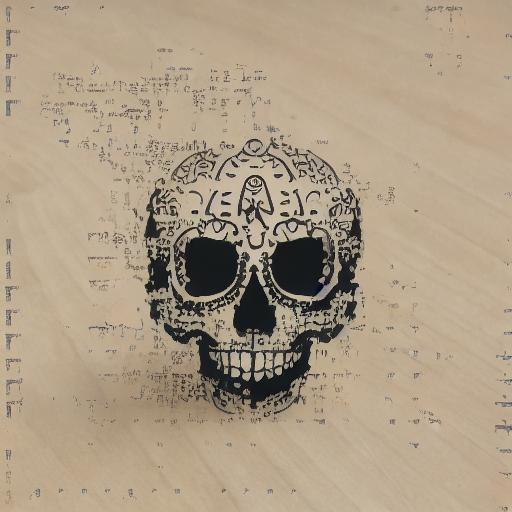

In [5]:
prompt = "A photo of a skull"

url = URL_API + "/transform"

encoded_image = encode_image_to_base64(image_path)
payload = {"image": encoded_image,
          "prompt": prompt}

response = requests.post(url, json=payload)

base64_image = response.text.replace("data:image/jpeg;base64,", "")
image_file = BytesIO(base64.b64decode(base64_image))

image = Image.open(image_file)

image

In [32]:
url = URL_API + "/locate_ip"

encoded_image = encode_image_to_base64(image_path)
payload = {"ip": "8.8.8.8"} # google DNS server

response = requests.post(url, json=payload)

response.json()

{'as': 'AS15169 Google LLC',
 'city': 'Ashburn',
 'country': 'United States',
 'countryCode': 'US',
 'isp': 'Google LLC',
 'lat': 39.03,
 'lon': -77.5,
 'org': 'Google Public DNS',
 'query': '8.8.8.8',
 'region': 'VA',
 'regionName': 'Virginia',
 'status': 'success',
 'timezone': 'America/New_York',
 'zip': '20149'}

In [16]:
ip = "8.8.8.8"
url = f'http://ip-api.com/json/{ip}'
response = requests.get(url)
response.raise_for_status()  # Raises an error for bad responses
response.json()  # Converts the JSON response to a Python dictionary

{'status': 'success',
 'country': 'United States',
 'countryCode': 'US',
 'region': 'VA',
 'regionName': 'Virginia',
 'city': 'Ashburn',
 'zip': '20149',
 'lat': 39.03,
 'lon': -77.5,
 'timezone': 'America/New_York',
 'isp': 'Google LLC',
 'org': 'Google Public DNS',
 'as': 'AS15169 Google LLC',
 'query': '8.8.8.8'}